In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from torchvision.utils import save_image
import sys

In [2]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False,transform=transforms.ToTensor())

In [4]:
train_data = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=64, 
                                           shuffle=True)
 
test_data = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=64, 
                                          shuffle=False)

In [5]:
class Denoiser(nn.Module):
    def __init__(self):
        #Encoder
        super(Denoiser, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.ReLU()
            nn.Linear(400, 20),
            nn.LeakyReLU(0.2, inplace=True)
            #nn.ReLU()
        )
    
        self.Decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.ReLU()
            nn.Linear(400, 784),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [6]:
Deno = Denoiser()

In [7]:
criterion = nn.BCELoss()
Deno_opt = torch.optim.Adam(Deno.parameters(), lr=0.001)

In [8]:
num_epochs = 10

In [9]:
loss_list = []
for epoch in range(num_epochs):
    loss_sum_in_epoch = 0
    for step,(x, _) in enumerate(train_data):
        if (x.shape[0] != 64):
            continue
        x = x.reshape(64,784)
        x_with_noise = x + 0.3 * torch.randn(x.shape)
        #x_with_noise = torch.tensor(x_with_noise, requires_grad=True)
        x_with_noise = torch.clamp(x_with_noise, 0.0, 1.0)
        #print(x_with_noise)
        Deno_outputs = Deno(x_with_noise)
        loss = criterion(Deno_outputs, x)
        #print(loss)
        Deno_opt.zero_grad()
        loss.backward()
        Deno_opt.step()
        loss_sum_in_epoch = loss_sum_in_epoch + loss.item()
    loss_list.append(loss_sum_in_epoch/937)
    print('Epoch[{}/{}]'.format(epoch+1,num_epochs))

Epoch[1/10]
Epoch[2/10]
Epoch[3/10]
Epoch[4/10]
Epoch[5/10]
Epoch[6/10]
Epoch[7/10]
Epoch[8/10]
Epoch[9/10]
Epoch[10/10]


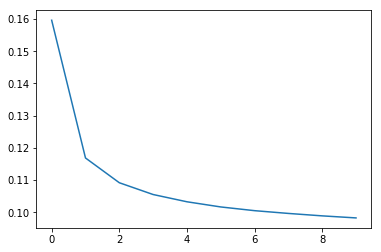

In [10]:
Loss_df = pd.DataFrame({'index': list(range(10)), 'Loss': loss_list})
plt.plot('index', 'Loss', data=Loss_df)

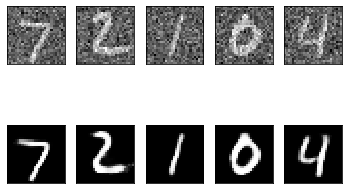

In [11]:
iterator = iter(test_data)
x_test, label = iterator.next()
x_test = x_test.reshape(64,784)
x_with_noise = x_test + 0.3 * torch.randn(x_test.shape, requires_grad=True)
#x_with_noise = torch.clamp(x_with_noise, 0.0, 1.0, out=None)
Deno_outputs = Deno(x_with_noise)
Deno_outputs = Deno_outputs.reshape(64,1,28,28)
x_with_noise_img = x_with_noise.detach().numpy().reshape(64, 1, 28, 28)
Deno_outputs = Deno_outputs.view(64, 1, 28, 28)
Deno_outputs = Deno_outputs.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for x_with_noise_img, row in zip([x_with_noise_img, Deno_outputs], axes):
    for img, ax in zip(x_with_noise_img, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [12]:
torch.save(Deno.state_dict(), 'hw5_dAE.pth')